In [86]:
import ee
ee.Initialize()

We are going to look at four different satellites.

COPERNICUS/S2: SENTINEL 2:   2 satellites (Sentinel 2A (from June 2015) and 2B(from March 2017)) 180 degrees apart in same orbit.  10-day revisit cycle for each one.

LANDSAT/LC08/C01/T1_SR:  LANDSAT 8: (from Feb 2013)

LANDSAT/LT05/C01/T1_SR:  LANDSAT 5: (from 1984)

LANDSAT/LT04/C01/T1_SR:  LANDSAT 4 (from 1982-93):


In [87]:
coords = [27.95,11.57]
geom = ee.Geometry.Point(coords)

In [115]:
def get_datetimes(collection_name, coords):
    geom = ee.Geometry.Point(coords)
    image_coll = ee.ImageCollection(collection_name).filterBounds(geom)
    def accumulate_timestamps(image, timestamps):
        ts = image.get('system:time_start')
        new_list = ee.List(timestamps)
        return ee.List(new_list.add(ts))
    ts_list = image_coll.iterate(accumulate_timestamps, ee.List([]))
    return ts_list.getInfo()

We want to make a dataframe with date index and log(time difference between successive images) columns.

In [116]:
import numpy as np
import pandas as pd
from datetime import datetime
def make_dataframe(timestamp_list):
    diffs = [int((timestamp_list[i] - timestamp_list[i-1])/1000) for i in range(1,len(timestamp_list))]
    log_diffs = [np.log(tsdiff) for tsdiff in diffs if tsdiff > 0]
    dates = [datetime.fromtimestamp(ts/1000) for ts in timestamp_list[1:]]
    timestamps = [ts/1000 for ts in timestamp_list[1:]]
    months = [str(date)[:7] for date in dates]
    df = pd.DataFrame({"Date": dates, "timestamp": timestamps, "diffs": diffs, "month": months})
    ## filter to exclude duplicate times
    df = df[df["diffs"] > 0]
    ## add log_diffs column, which was only computed for non-zero time differences.
    df["log_diffs"] = log_diffs
    return df


In [117]:
sentinel2 = get_datetimes("COPERNICUS/S2", coords)
landsat8 = get_datetimes("LANDSAT/LC08/C01/T1_SR", coords)


In [100]:
df = make_dataframe(sentinel2)
df.head()

,Date,timestamp,diffs,month,log_diffs
5,2015-09-22 09:28:49.000,1.442911e+09,863989,2015-09,13.669315
9,2015-10-22 09:45:12.000,1.445504e+09,2592982,2015-10,14.768319
13,2015-11-21 08:39:06.000,1.448095e+09,2591633,2015-11,14.767799
19,2015-12-11 08:44:15.000,1.449823e+09,1728308,2015-12,14.362653
23,2015-12-11 08:54:57.608,1.449824e+09,642,2015-12,6.464588


In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

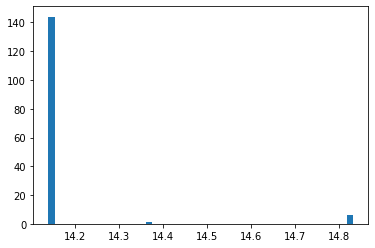

In [78]:
ax = plt.hist(df.log_diffs, bins=50)
plt.xlabel = "log(time (s) between images)"
plt.show()

In [122]:
def create_2d_hist(df):
    num_months = len(df["month"].unique())
    H,xedges,yedges = np.histogram2d(df['timestamp'], df['log_diffs'], bins=[num_months,50])
    to_datetime = np.vectorize(datetime.fromtimestamp)
    xedges_datetime = to_datetime(xedges)
    return H, xedges_datetime, yedges 


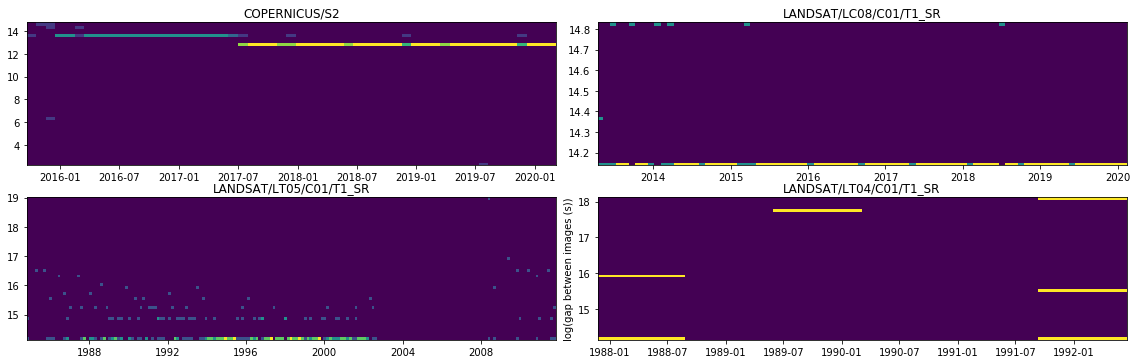

In [133]:
fig, axes = plt.subplots(2, 2, figsize=(16,5))
fig.tight_layout()
image_colls = ["COPERNICUS/S2",
               "LANDSAT/LC08/C01/T1_SR",
               "LANDSAT/LT05/C01/T1_SR",
               "LANDSAT/LT04/C01/T1_SR"]
for i, ic in enumerate(image_colls):
    timestamps = get_datetimes(ic, coords)
    dataframe = make_dataframe(timestamps)
    H, xedges, yedges = create_2d_hist(dataframe)
    fig_row = (i//2) 
    fig_col = i%2
    axes[fig_row][fig_col].pcolor(xedges, yedges, H.T)
    axes[fig_row][fig_col].set_title(ic)
    plt.ylabel('log(gap between images (s))')